In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import tqdm

In [2]:
A = np.genfromtxt("blurred_img_psf.csv", delimiter=',')
img = A[0:255,0:255]
psf = A[0:255,256:511]

In [3]:
def RLconv(img, PSF, iters):
    temp_img = img+0j
    F_PSF = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(PSF)))
    F_PSF_hat = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(PSF[::-1,::-1])))
    for i in tqdm.tqdm(range(iters)):
        F_denm = F_PSF*np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(temp_img)))
        A = img/np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(F_denm)))
        F_B = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(A)))*F_PSF_hat
        B = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(F_B)))
        temp_img *= B
    return np.abs(temp_img)

In [4]:
def cost_function(g_out, g, alpha):
    term_1 = (np.linalg.norm(g_out - g, 'fro'))**2
    gy, gx = np.gradient(g)
    total_variation = np.sum(np.sqrt(gx**2 + gy**2))
    term_2 = alpha * total_variation
    return term_1 + term_2

In [5]:
def cost_functional_gradient(g_out, g, alpha, epsilon):
    gy, gx = np.gradient(g)
    temp = np.sqrt(gx**2 + gy**2 + epsilon**2)
    TV_grad = -alpha*(np.gradient(gx/temp)[1] + np.gradient(gy/temp)[0])
    return 2*(g - g_out) + TV_grad

In [6]:
def TV_denoising(g_out, alpha, initial_guess, initial_step=1, epsilon = 1e-6, next_step = lambda x: 0.5*x, threshold = 5e-7):
    g = initial_guess
    tau = initial_step
    while True:
        func_grad = cost_functional_gradient(g_out, g, alpha, epsilon)
        norm_func_grad = np.linalg.norm(func_grad, 'fro')
        if ((tau*norm_func_grad) < (threshold*np.linalg.norm(g, 'fro'))):
            break
        else:
            g_try = g - tau*func_grad
            Cost_g = cost_function(g_out, g, alpha)
            Cost_try = cost_function(g_out, g_try, alpha)
            if (Cost_try < Cost_g):
                g = g_try
            else:
                tau = next_step(tau)
    return np.abs(g)

In [19]:
img_new = RLconv(img, psf, 400)
# img_new1 = RLconv2(img,psf, 500)

100%|████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 53.48it/s]


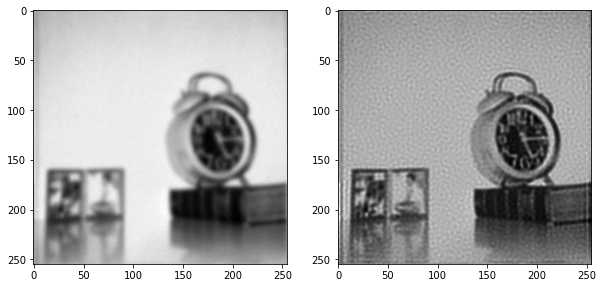

In [20]:
im, ax = plt.subplots(1, 2, figsize= (10,50))
ax[0].imshow(img, cmap='gray')
# ax[0].set_title('Original Image')
ax[1].imshow(img_new, cmap='gray')
# ax[1].set_title('Iterated Image')

In [25]:
y_denoised = TV_denoising(img_new, 2000, np.random.randint(0, 255, img_new.shape))

Text(0.5, 1.0, 'Deblurred and Reconstructed Image')

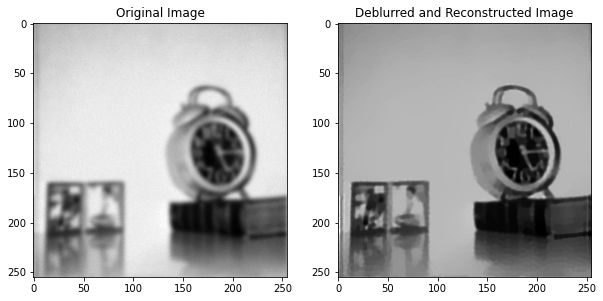

In [24]:
im, ax = plt.subplots(1, 2, figsize= (10,50))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(y_denoised, cmap='gray')
ax[1].set_title('Deblurred and Reconstructed Image')

In [41]:
from PIL import Image

In [42]:
input = 'img.jpeg'
img = Image.open(input)
img = img.convert('L')
img = img.resize((200,200))
img_arr = np.asarray(img)

In [47]:
y_img_denoised = TV_denoising(img_arr, 5, np.random.randint(0, 255, img_arr.shape))

Text(0.5, 1.0, 'Deblurred and Reconstructed Image')

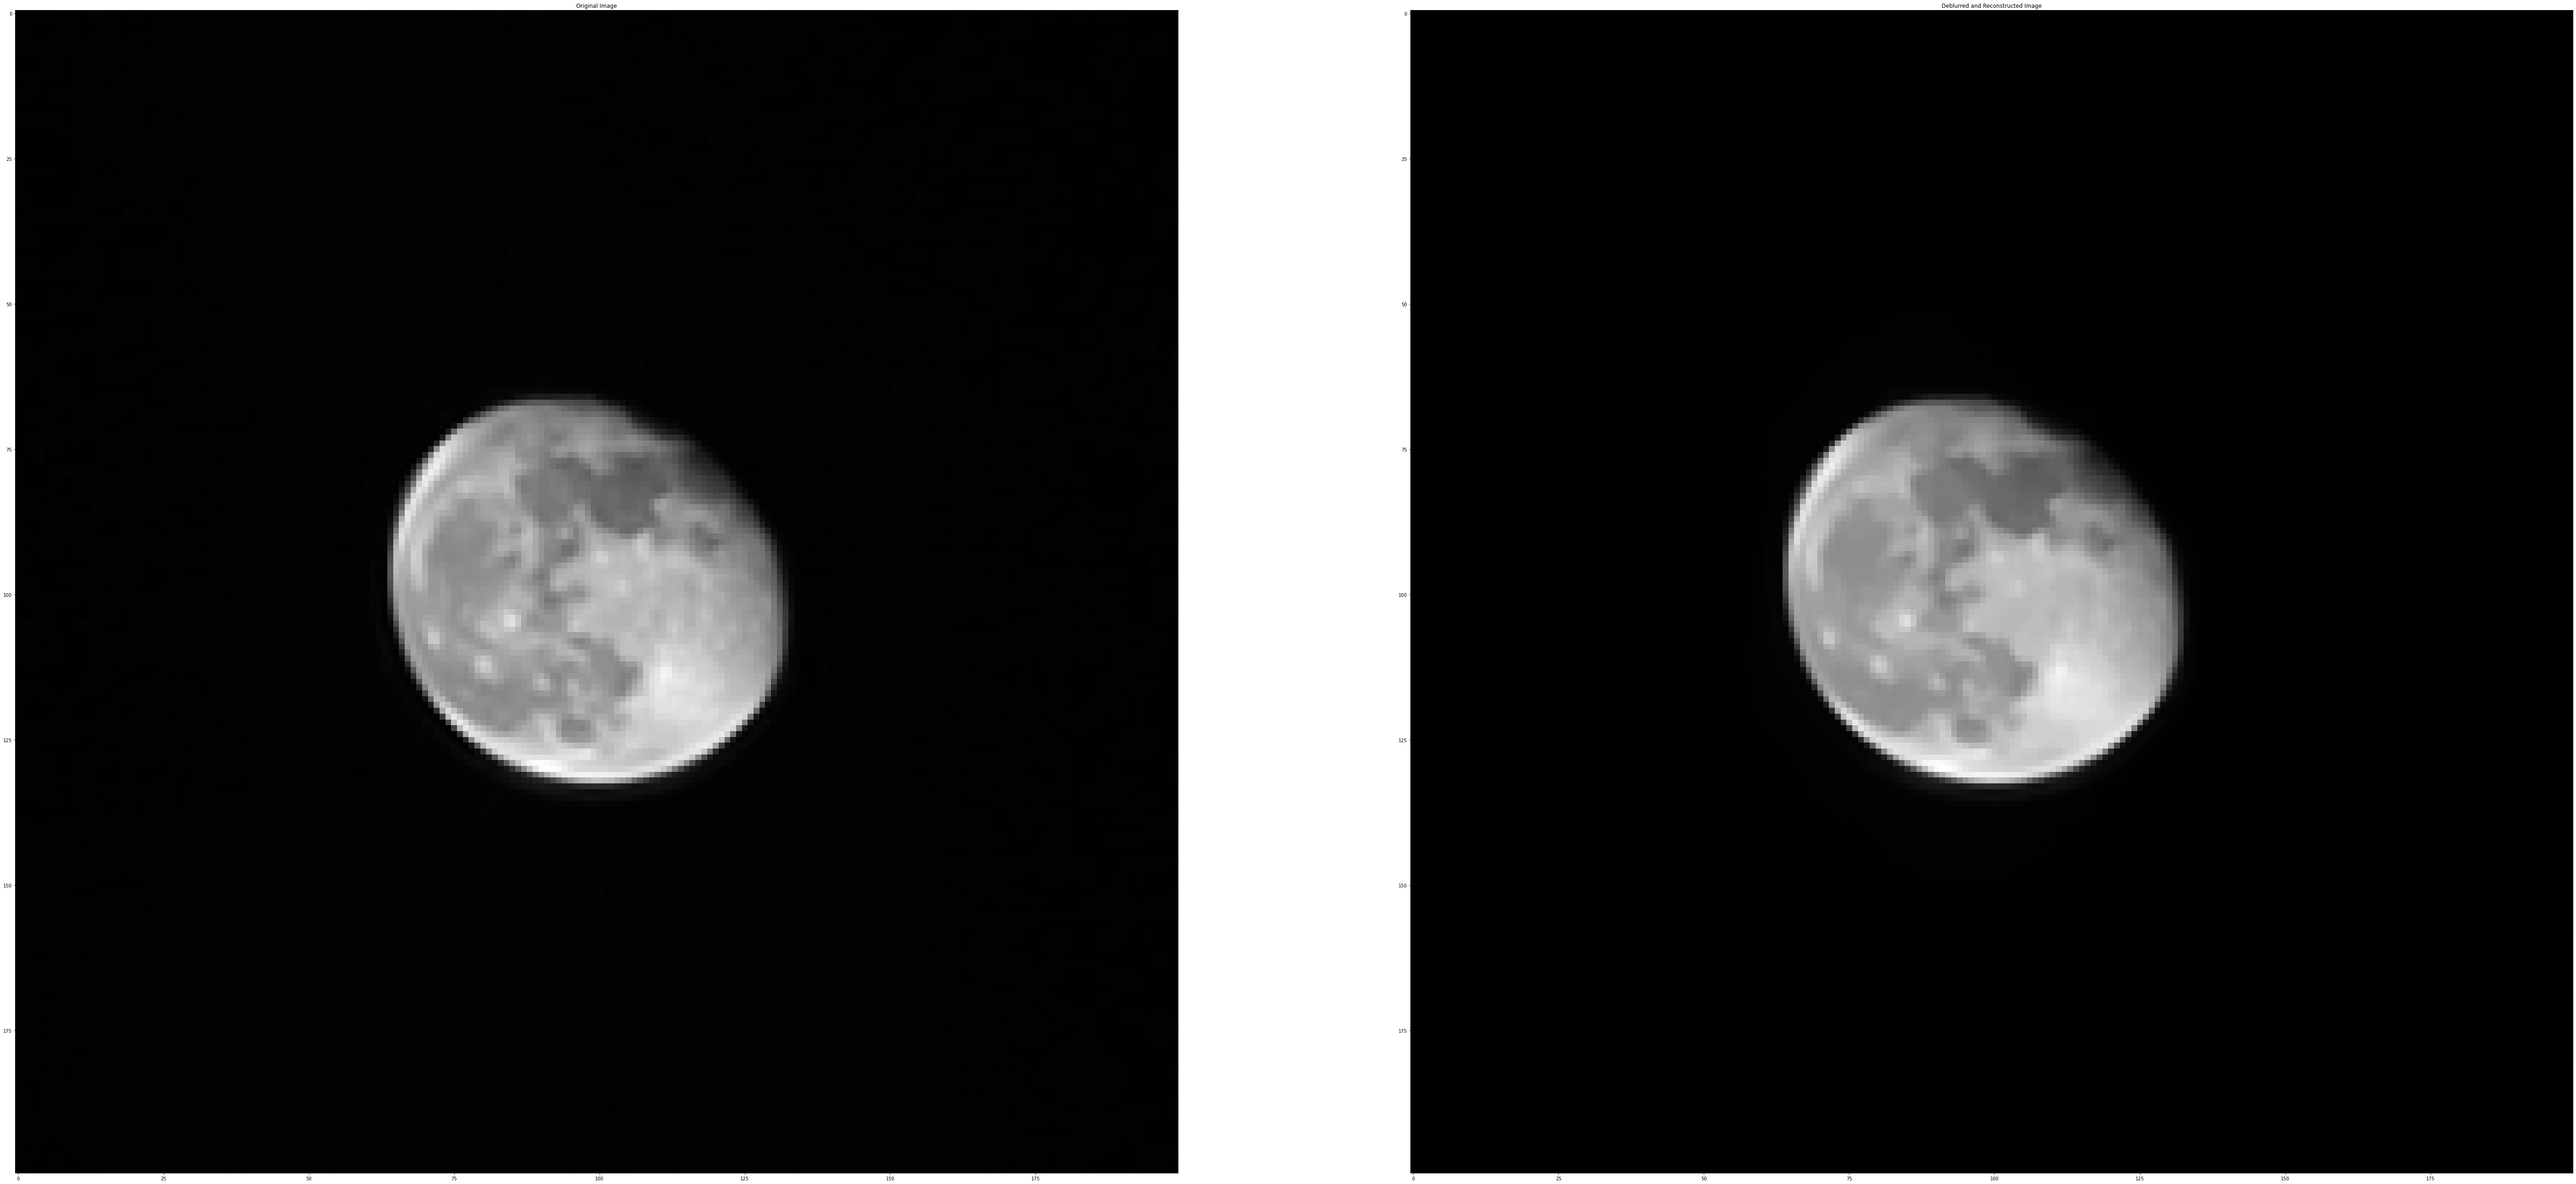

In [48]:
im, ax = plt.subplots(1, 2, figsize= (100,500))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(y_img_denoised, cmap='gray')
ax[1].set_title('Deblurred and Reconstructed Image')